In [6]:
from commonfunctions import *

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier  # MLP is an NN
from sklearn import svm
import numpy as np
import argparse
import cv2
import os
import random


# Depending on library versions on your system, one of the following imports 
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

In [8]:
path_to_dataset = r'digits_dataset'
target_img_size = (32, 32) # fix image size because classification algorithms THAT WE WILL USE HERE expect that

# We are going to fix the random seed to make our experiments reproducible 
# since some algorithms use pseudorandom generators
random_seed = 42  
random.seed(random_seed)
np.random.seed(random_seed)

In [9]:
def extract_hog_features(img):
    """
    TODO
    You won't implement anything in this function. You just need to understand it 
    and understand its parameters (i.e win_size, cell_size, ... etc)
    """
    img = cv2.resize(img, target_img_size)
    win_size = (32, 32)
    cell_size = (4, 4)
    block_size_in_cells = (2, 2)
    
    block_size = (block_size_in_cells[1] * cell_size[1], block_size_in_cells[0] * cell_size[0])
    block_stride = (cell_size[1], cell_size[0])
    nbins = 9  # Number of orientation bins
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    h = hog.compute(img)
    h = h.flatten()
    return h.flatten()

In [10]:
def load_dataset():
    features = []
    labels = []

    # Iterate through subfolders (assume folder name is the label)
    for label_folder in os.listdir(path_to_dataset):
        label_path = os.path.join(path_to_dataset, label_folder)
        
        # Ensure it's a directory (skip files)
        if not os.path.isdir(label_path):
            continue
        
        # Extract label from the folder name
        label = label_folder
        
        # Iterate through the images in the folder
        for img_filename in os.listdir(label_path):
            if img_filename.lower().endswith('.jpg'):  # Process only .jpg files
                img_path = os.path.join(label_path, img_filename)
                
                # Read image
                img = cv2.imread(img_path)
                
                # Extract features (e.g., HOG features)
                features.append(extract_hog_features(img))
                
                # Append the label
                labels.append(label)
                
                # Show an update every 1,000 images
                if len(features) % 1000 == 0:
                    print(f"[INFO] Processed {len(features)} images so far.")

    return features, labels


In [11]:
# TODO understand the hyperparameters of each classifier
classifiers = {
    # 'SVM': svm.LinearSVC(random_state=random_seed),
    'KNN': KNeighborsClassifier(n_neighbors=7)
    # 'NN': MLPClassifier(solver='sgd', random_state=random_seed, hidden_layer_sizes=(500,), max_iter=20, verbose=1)
}

In [12]:
# This function will test all our classifiers on a specific feature set
def run_experiment():
    
    # Load dataset with extracted features
    print('Loading dataset. This will take time ...')
    features, labels = load_dataset()
    print('Finished loading dataset.')
    
    # Since we don't want to know the performance of our classifier on images it has seen before
    # we are going to withhold some images that we will test the classifier on after training 
    train_features, test_features, train_labels, test_labels = train_test_split(
        features, labels, test_size=0.2, random_state=random_seed)
    
    for model_name, model in classifiers.items():
        print('############## Training', model_name, "##############")
        # Train the model only on the training features
        model.fit(train_features, train_labels)
        
        # Test the model on images it hasn't seen before
        accuracy = model.score(test_features, test_labels)
        
        print(model_name, 'accuracy:', accuracy*100, '%')

In [13]:
run_experiment()
"""
You should get the following test accuracies the first time 

SVM accuracy ~ 97.70833333333333
KNN accuracy ~ 96.52777777777779
NN accuracy ~ 93.95833333333333
"""

Loading dataset. This will take time ...
[INFO] Processed 1000 images so far.
[INFO] Processed 2000 images so far.
[INFO] Processed 3000 images so far.
[INFO] Processed 4000 images so far.
[INFO] Processed 5000 images so far.
[INFO] Processed 6000 images so far.
[INFO] Processed 7000 images so far.
[INFO] Processed 8000 images so far.
[INFO] Processed 9000 images so far.
[INFO] Processed 10000 images so far.
[INFO] Processed 11000 images so far.
[INFO] Processed 12000 images so far.
[INFO] Processed 13000 images so far.
[INFO] Processed 14000 images so far.
[INFO] Processed 15000 images so far.
[INFO] Processed 16000 images so far.
[INFO] Processed 17000 images so far.
[INFO] Processed 18000 images so far.
[INFO] Processed 19000 images so far.
[INFO] Processed 20000 images so far.
[INFO] Processed 21000 images so far.
[INFO] Processed 22000 images so far.
[INFO] Processed 23000 images so far.
[INFO] Processed 24000 images so far.
[INFO] Processed 25000 images so far.
[INFO] Processed 2

'\nYou should get the following test accuracies the first time \n\nSVM accuracy ~ 97.70833333333333\nKNN accuracy ~ 96.52777777777779\nNN accuracy ~ 93.95833333333333\n'

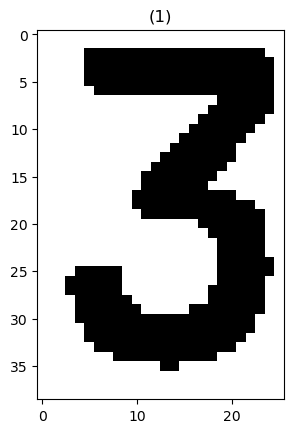

In [14]:
# Example
test_img_path = r'template/number3.png'
img = cv2.imread(test_img_path)
temp = np.copy(img)
img [temp <= 150] = 0
img [temp > 150] = 255
show_images([img])
features = extract_hog_features(img)  # be careful of the choice of feature set

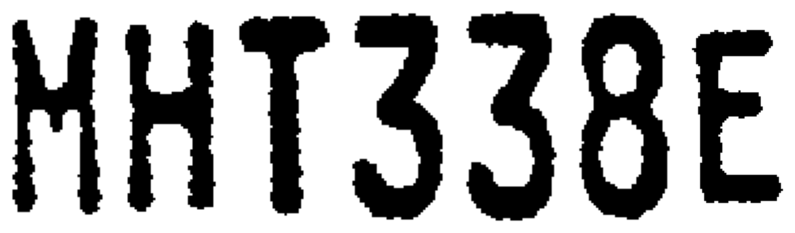

In [123]:

def segment_characters(image_path, output_directory):
    """
    Segments characters from an image and saves them as individual images.

    Args:
        image_path (str): Path to the input image.
        output_directory (str): Directory to save the segmented character images.

    Returns:
        list: List of segmented character images as numpy arrays.
    """
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply binary thresholding
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

    # Find contours of the characters
    contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort contours from left to right
    sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    # Initialize list to store segmented characters
    segmented_characters = []

    # Loop through contours and extract individual characters
    for i, contour in enumerate(sorted_contours):
        width, height = image.shape
        x, y, w, h = cv2.boundingRect(contour)
        # Filter out small contours
        if w > width/10 and h > height/10 and w < width*3/4 and h < height*1/5:
            char_image = binary_image[y:y+h, x:x+w]
            segmented_characters.append(char_image)
            # Save the segmented character image
            cv2.imwrite(f"{output_directory}/char_{i}.png", char_image)

    return segmented_characters

# Example usage
image_path = "../trial-2/outputs/output-3.png"
img = cv2.imread(image_path)
output_directory = "/mnt/data/segmented_chars"
segmented_characters = segment_characters(image_path, output_directory)

# Display segmented characters
plt.figure(figsize=(10, 5))
for i, char_image in enumerate(segmented_characters):
    plt.subplot(1, len(segmented_characters), i + 1)
    plt.imshow(char_image, cmap='gray')
    plt.axis("off")
    
plt.show()


In [124]:
knn = classifiers['KNN']

for i, char_image in enumerate(segmented_characters):
    features = extract_hog_features(char_image)
    print(knn.predict([features]))

['M']
['H']
['T']
['3']
['3']
['8']
['E']
